In [2]:
import pandas as pd  
import numpy as np
from heatmap import corrplot
from cryptocmd import CmcScraper
import matplotlib.pyplot as plt


In [3]:
Currencies= ['BTC','DOT','ETH','ADA','NANO','LINK']

In [4]:
num_asset = len(Currencies)

data = [CmcScraper(x).get_dataframe()['Close'].rename(x) for x in Currencies]
stardate = min([len(x) for x in data])-1
dfs = [x.truncate(after=stardate) for x in data]

df_date = CmcScraper(Currencies[0]).get_dataframe()['Date'].rename('Date')
df_date = df_date.truncate(after=stardate)


dfs= [df_date]+dfs
df_final = pd.concat(dfs, axis=1).set_index('Date')

           BTC       DOT       ETH       ADA      NANO      LINK
BTC   1.000000  0.942008  0.800467  0.777390  0.831308  0.878940
DOT   0.942008  1.000000  0.777695  0.781375  0.865350  0.934538
ETH   0.800467  0.777695  1.000000  0.948747  0.922457  0.839140
ADA   0.777390  0.781375  0.948747  1.000000  0.890360  0.769394
NANO  0.831308  0.865350  0.922457  0.890360  1.000000  0.916211
LINK  0.878940  0.934538  0.839140  0.769394  0.916211  1.000000


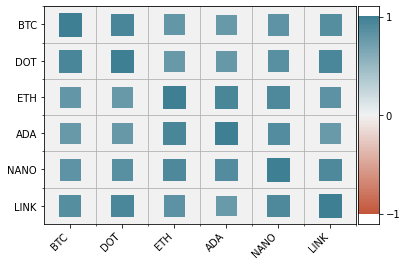

In [5]:
## Abs return
dfs2 = [df_final[x]/df_final[x][-1] for x in Currencies]
df = pd.concat(dfs2, axis=1)


# Corrolation Matrix
corr_matrix = df.corr()
print(corr_matrix)
corr_plot = corrplot(corr_matrix, size_scale=500, marker='s')

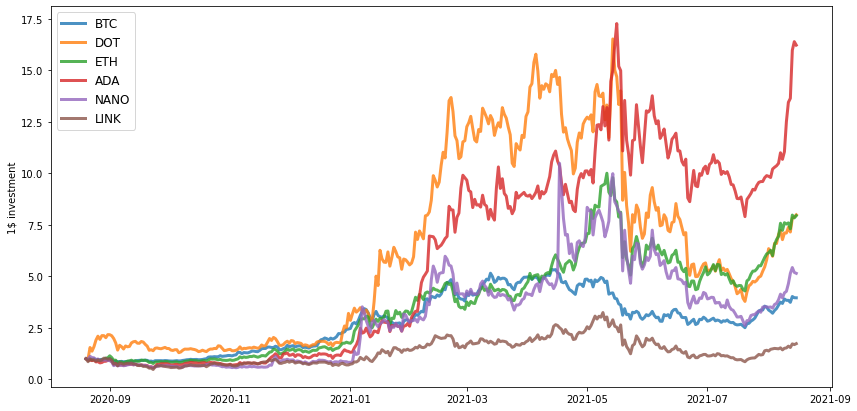

In [6]:
# Abs return graphed
table = df

plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('1$ investment')


table=table.iloc[::-1]
returns = table.pct_change()

In [7]:
## functions for portfolio generation
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_asset) 
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [8]:
# generating portfolios
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 500000
risk_free_rate = 0.0178


results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
max_sharpe_idx = np.argmax(results[2])
sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T
    
min_vol_idx = np.argmin(results[0])
sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T
    

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 2.14
Annualised Volatility: 0.87


              BTC   DOT    ETH    ADA  NANO  LINK
allocation  16.75  2.94  25.93  50.39  3.95  0.04
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 1.34
Annualised Volatility: 0.66


              BTC   DOT   ETH  ADA  NANO  LINK
allocation  83.31  1.97  2.24  8.6  0.88  3.01


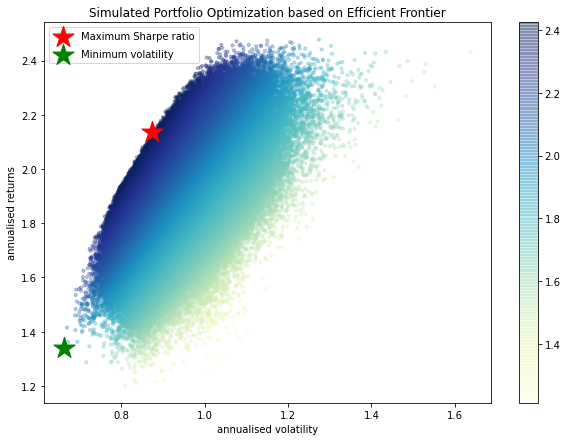

In [9]:
# effecient frontier    
print ("-"*80)
print ("Maximum Sharpe Ratio Portfolio Allocation\n")
print ("Annualised Return:", round(rp,2))
print ("Annualised Volatility:", round(sdp,2))
print ("\n")
print (max_sharpe_allocation)
print ("-"*80)
print ("Minimum Volatility Portfolio Allocation\n")
print ("Annualised Return:", round(rp_min,2))
print ("Annualised Volatility:", round(sdp_min,2))
print ("\n")
print (min_vol_allocation)
    
plt.figure(figsize=(10, 7))
plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar()
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend(labelspacing=0.8)

Text(0, 0.5, '1$ investment')

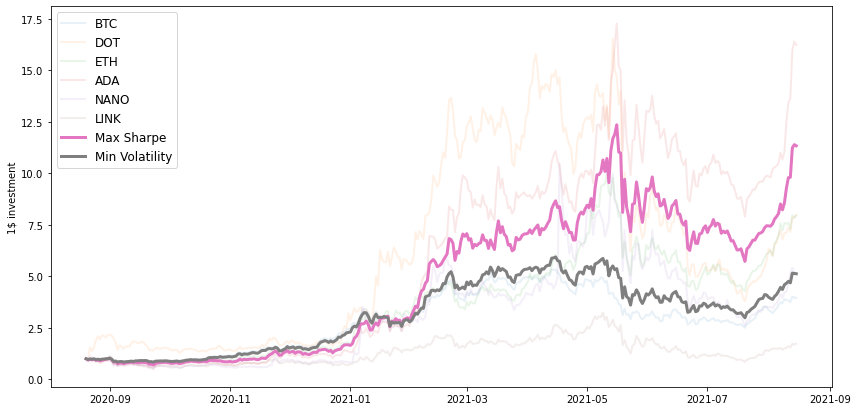

In [12]:
## Creating optimal portfolios ##
# max sharpe portfolio
max_sharpe_weights = [x for x in max_sharpe_allocation.iloc[0,:]]
max_sharpe_weights = [x/100 for x in max_sharpe_weights]
df_sharpe = df * max_sharpe_weights
df_sharpe = df_sharpe.sum(axis = 1)
df_sharpe = df_sharpe.rename('Max Sharpe')
#min volatility portfolio
min_vol_weights = [x for x in min_vol_allocation.iloc[0,:]]
min_vol_weights = [x/100 for x in min_vol_weights]
df_min_vol = df * min_vol_weights
df_min_vol = df_min_vol.sum(axis = 1)
df_min_vol = df_min_vol.rename('Min Volatility')


## ploting portfolios against assets
df_portfolios = pd.concat([df, df_sharpe,df_min_vol], axis=1)
table = df_portfolios

plt.figure(figsize=(14, 7))
for c in table.columns.values[:-2]:
    plt.plot(table.index, table[c], lw=2, alpha=0.1,label=c)
for c in table.columns.values[-2:]:
    plt.plot(table.index, table[c], lw=3, alpha=1,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('1$ investment')